In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
from decouple import config
import json
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from authenticate_service_account import main
from utils import *

from sklearn.model_selection import train_test_split

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

import category_encoders as ce
from scipy import stats

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor

from keras.models import load_model

from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, Sequential

from joblib import dump, load

from sklearn.ensemble import RandomForestRegressor


In [2]:
def ants_preprocess(data):
    data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])

    data_with_layover = calculate_total_layover_time(data_with_od, as_ratio=True)

    data_with_layover2 = calculate_distance_difference(data_with_layover, as_ratio=True)

    data_with_redirect_ratio = redirect_ratio(data_with_layover2)

    droped_values = drop_neg_layover_time(data_with_redirect_ratio)

    return droped_values


In [3]:
def convert_bool_to_num(value):
    return 0 if value else 1


In [4]:
data = pd.read_csv('../raw_data/all_data_30_horizon_with_day_of_week')
data.dropna(subset=['OriginApt', 'DestinationCty'], inplace=True)


In [5]:
economy_flights = data[data['PricePerPax']< 1500].copy()


In [6]:
processed_data = ants_preprocess(economy_flights)


In [7]:
# Creating our target
df_with_target = scale_itin_redirects(processed_data, 'ItineraryRedirects', 0, 50)


In [8]:
# df_with_target = make_target[(make_target['Score_Z_score_0_50'] > 1) & (make_target['ODRedirects'] > 10)]


In [9]:
# fig, axs = plt.subplots(4, 1, figsize=(20, 20))
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='Score_Z_score_0_50', hue='redirect_ratio', ax=axs[0], legend=False)
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='Score_Z_score', hue='redirect_ratio', ax=axs[1], legend=False)
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='Score_min_max', hue='redirect_ratio', ax=axs[2], legend=False)
# sns.scatterplot(data=df_with_target, x='ODRedirects', y='MinMax_Scaled', hue='redirect_ratio', ax=axs[3], legend=False)

# for ax in axs:
#     ax.set_xlim(-5, 500)


In [10]:
columns = ['Stops','DurationMin', 'total_layover_time_ratio', 'OriginApt', 'DestinationApt',
            'total_distance_traveled','extra_travel_distance_ratio', 'TravelHorizonDays', 'dayofweek',
            'Seg_0_OperatingCarrierIATA', 'Seg_1_OperatingCarrierIATA', 'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA',
            'TravelDistanceKm', 'PricePerPax', 'SelfTransfer', "Score_Z_score_0_50"]

box_cox_columns = ['DurationMin', 'TravelDistanceKm','extra_travel_distance_ratio', 'PricePerPax']

yeo_johnson_columns = ['total_layover_time_ratio']

min_max_scaling = ['TravelHorizonDays','Stops']


In [11]:
df_with_target[columns].shape


(3597748, 17)

In [12]:
def feature_engineering(processed_data, list_of_columns,
                        box_cox_columns, yeo_johnson_columns, min_max_scaling,
                        return_encoders=False):

    model_data = processed_data[list_of_columns]

    print(model_data.shape)

    #Binary encoding origin and destination
    o_encoder = ce.BinaryEncoder(cols=['OriginApt'])
    df_binary = o_encoder.fit_transform(model_data)

    print(df_binary.shape)

    d_encoder = ce.BinaryEncoder(cols=['DestinationApt'])
    all_binary = d_encoder.fit_transform(df_binary)

    print(all_binary.shape)
    # Scaling other features

    # Box cox
    for col in box_cox_columns:
        all_binary[col], box_lambda = stats.boxcox(all_binary[col])

    print(all_binary.shape)


    # Yeo-johnson
    for col in yeo_johnson_columns:
        all_binary[col], yeo_lambda = stats.yeojohnson(all_binary[col])

    print(all_binary.shape)


    #Min max scaling
    minmax_scaler = MinMaxScaler()
    all_binary[min_max_scaling] = minmax_scaler.fit_transform(all_binary[min_max_scaling])

    print(all_binary.shape)


    # Cyclical encoding
    all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
    all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

    all_binary.drop(columns='dayofweek', inplace=True)

    print(all_binary.shape)


    # Binary encoding Operator IATA'
    seg_0_encoder = ce.BinaryEncoder(cols=['Seg_0_OperatingCarrierIATA'])
    seg_0_binary = seg_0_encoder.fit_transform(all_binary)

    seg_1_encoder = ce.BinaryEncoder(cols=['Seg_1_OperatingCarrierIATA'])
    seg_1_binary = seg_1_encoder.fit_transform(seg_0_binary)

    seg_2_encoder = ce.BinaryEncoder(cols=['Seg_2_OperatingCarrierIATA'])
    seg_2_binary = seg_2_encoder.fit_transform(seg_1_binary)

    seg_3_encoder = ce.BinaryEncoder(cols=['Seg_3_OperatingCarrierIATA'])
    seg_3_binary = seg_3_encoder.fit_transform(seg_2_binary)

    if return_encoders == False:
        return seg_3_binary
    else:
        class PreprocessScalers:
            def __init__(self, o_encoder, d_encoder, box_lambda, yeo_lambda, minmax_scaler, seg_0_encoder, seg_1_encoder, seg_2_encoder, seg_3_encoder):
                self.o_encoder = o_encoder
                self.d_encoder = d_encoder
                self.box_lambda = box_lambda
                self.yeo_lambda = yeo_lambda
                self.minmax_scaler = minmax_scaler
                self.seg_0_encoder = seg_0_encoder
                self.seg_1_encoder = seg_1_encoder
                self.seg_2_encoder = seg_2_encoder
                self.seg_3_encoder = seg_3_encoder

        scalers = PreprocessScalers(o_encoder, d_encoder, box_lambda, yeo_lambda, minmax_scaler, seg_0_encoder, seg_1_encoder, seg_2_encoder, seg_3_encoder)

        return seg_3_binary, scalers


In [13]:
model_ready_data, PreprocessScalers = feature_engineering(df_with_target, columns,
                                       box_cox_columns, yeo_johnson_columns, min_max_scaling, return_encoders=True)


(3597748, 17)
(3597748, 28)
(3597748, 39)
(3597748, 39)
(3597748, 39)
(3597748, 39)
(3597748, 40)


In [14]:
model_ready_data['Score_Z_score_0_50'] = model_ready_data['Score_Z_score_0_50'].fillna(0)


In [15]:
model_ready_data['SelfTransfer'] = model_ready_data['SelfTransfer'].apply(convert_bool_to_num)


In [16]:
clean_and_processed_data = model_ready_data.copy()


# Modelin'

In [19]:
X_train, X_test, y_train, y_test = train_test_split(clean_and_processed_data.drop('Score_Z_score_0_50',
                                                                                axis=1), clean_and_processed_data['Score_Z_score_0_50'], random_state=42)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(processed_data.drop('Seg_3_OperatingCarrierIATA',
                                                                                axis=1), processed_data['Seg_3_OperatingCarrierIATA'], random_state=42)


In [20]:
X_train.shape


(2698311, 73)

In [87]:
model = Sequential()
model.add(layers.Dense(128, input_dim=73, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [88]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='min', restore_best_weights=True)


In [89]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [90]:
model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/10
8433/8433 [==============================] - 13s 2ms/step - loss: 10.0158 - mae: 1.0398 - val_loss: 1.9359 - val_mae: 0.8519
Epoch 2/10
8433/8433 [==============================] - 12s 1ms/step - loss: 1.8539 - mae: 0.8793 - val_loss: 1.7758 - val_mae: 0.8790
Epoch 3/10
8433/8433 [==============================] - 12s 1ms/step - loss: 1.7767 - mae: 0.8581 - val_loss: 1.7448 - val_mae: 0.8548
Epoch 4/10
8433/8433 [==============================] - 11s 1ms/step - loss: 1.7625 - mae: 0.8563 - val_loss: 1.7460 - val_mae: 0.8341
Epoch 5/10
8433/8433 [==============================] - 12s 1ms/step - loss: 1.7520 - mae: 0.8554 - val_loss: 1.7361 - val_mae: 0.8629
Epoch 6/10
8433/8433 [==============================] - 13s 2ms/step - loss: 1.7459 - mae: 0.8550 - val_loss: 1.7343 - val_mae: 0.8545
Epoch 7/10
8433/8433 [==============================] - 12s 1ms/step - loss: 1.7418 - mae: 0.8543 - val_loss: 1.7344 - val_mae: 0.8715
Epoch 8/10
8433/8433 [==============================] 

In [91]:
# model = load_model('../models/ant_model_021223.h5')
model.save('../models/ant_model_111223_v3.h5')


/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [92]:
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


28108/28108 [==============================] - 11s 378us/step - loss: 1.7219 - mae: 0.8243
Test Loss (MSE): 1.721914529800415
Test Error (MAE): 0.824326753616333


In [93]:
y_pred = model.predict(X_test)


28108/28108 [==============================] - 10s 363us/step


In [94]:
y_pred.reshape(-1)


array([2.8837261, 2.762924 , 2.56398  , ..., 2.9112108, 2.9010453,
       2.7314959], dtype=float32)

In [95]:
knn_50_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':y_pred.reshape(-1), 'DurationMin':X_test['DurationMin'],
                                  "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
                                  'Stops':X_test_all['Stops'], 'redirect_ratio':X_test_all['redirect_ratio']})

knn_50_performance_df['difference'] = knn_50_performance_df['pred_value'] - knn_50_performance_df['true_value']


<Axes: xlabel='ODRedirects', ylabel='difference'>

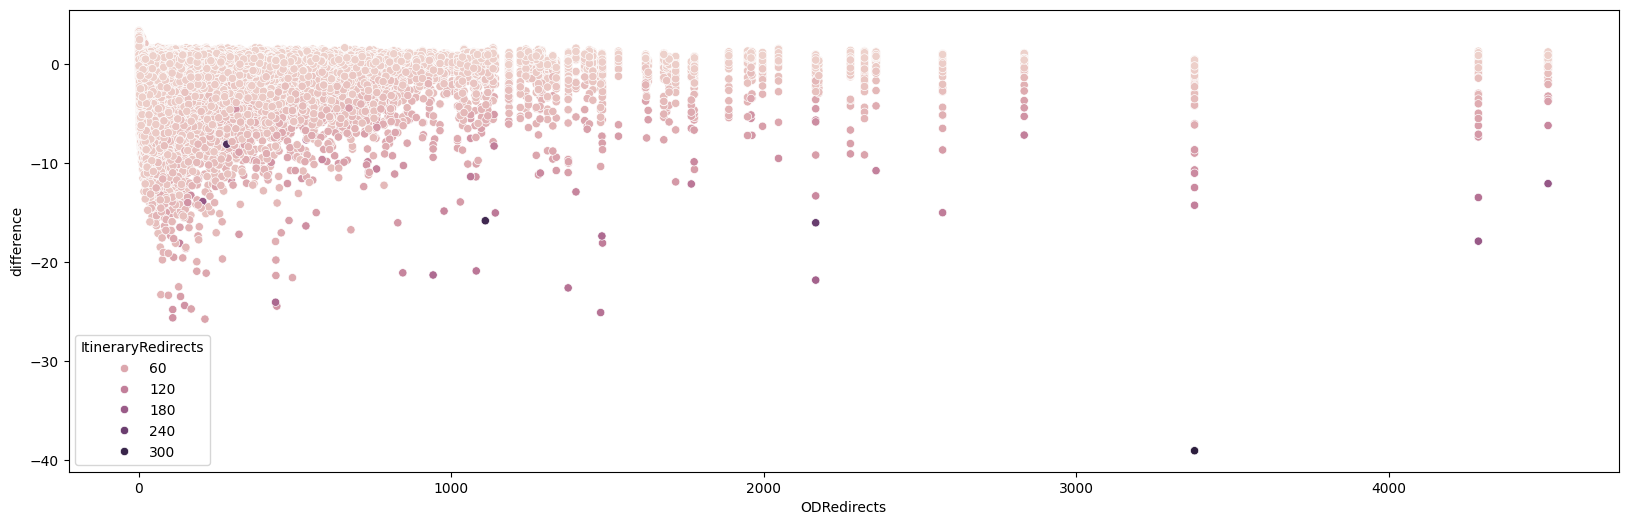

In [96]:
plt.figure(figsize=(20, 6))
sns.scatterplot(knn_50_performance_df, x='ODRedirects', y='difference', alpha=1, hue='ItineraryRedirects')


# Random Forrest model

In [69]:
# rf_regressor = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=20, )

# rf_regressor.fit(X_train, y_train)


In [ ]:
# rf_y_pred = rf_regressor.predict(X_test)

# rf_y_pred.reshape(-1)

# rf_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':rf_y_pred.reshape(-1), 'DurationMin':X_test['DurationMin'],
#                                   "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
#                                   'Stops':X_test_all['Stops'], 'redirect_ratio':X_test_all['redirect_ratio']})

# rf_performance_df['difference'] = rf_performance_df['pred_value'] - rf_performance_df['true_value']


In [ ]:
# plt.figure(figsize=(20, 6))
# sns.scatterplot(rf_performance_df, x='ODRedirects', y='difference', alpha=1, hue='ItineraryRedirects')


# Dohop test dataset

In [64]:
raw_dohop_data = pd.read_csv('../raw_data/bq-results-20231211-194938-1702324257187.csv')

copy_data = raw_dohop_data.copy()

dohop_data = copy_data[~copy_data['itinerary_fare'].isna()]


In [65]:
dohop_data.reset_index(drop=True, inplace=True)


In [66]:
dohop_data['seg_0'] = 0
dohop_data['seg_1'] = 0

for i in range(len(dohop_data)):
    listtt = dohop_data['flights'][i].split(',')
    dohop_data['seg_0'][i] = listtt[0][:2]
    dohop_data['seg_1'][i] = listtt[1].strip()[:2]


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_13244/3831053749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['seg_0'] = 0
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_13244/3831053749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['seg_1'] = 0
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_13244/3831053749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [67]:
dohop_data['DurationMin'] = dohop_data['total_flight_time'] + dohop_data['connection_time']
dohop_data['total_layover_time_ratio'] = dohop_data['connection_time'] / dohop_data['DurationMin']


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_13244/1285210725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['DurationMin'] = dohop_data['total_flight_time'] + dohop_data['connection_time']
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_13244/1285210725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['total_layover_time_ratio'] = dohop_data['connection_time'] / dohop_data['DurationMin']


In [68]:
# This was for an old dataset

# col_rename_dict = {'origin': 'OriginApt', 'destination':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'total_distance_traveled',
#                    'direct_distance':'TravelDistanceKm', 'total_minutes':'DurationMin', 'connection_time':'total_layover_time',
#                    'seg_0':'Seg_0_OperatingCarrierIATAa', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}


col_rename_dict = {'origin_iata': 'OriginApt', 'destination_iata':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'total_distance_traveled',
                   'direct_distance':'TravelDistanceKm', 'connection_time':'total_layover_time', 'itinerary_fare':'PricePerPax',
                   'seg_0':'Seg_0_OperatingCarrierIATA', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}


In [69]:
dohop_data.drop(columns=['flights', 'connection_airport', 'pax',
                         'bookings', 'booked_fare', 'total_flight_time'], inplace=True)


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_13244/2724626855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data.drop(columns=['flights', 'connection_airport', 'pax',


In [70]:
def create_df_of_all_categories(raw_data, data_to_be_processed, column):
    """
    This creates a list of all categories, and appends it to existing data that needs processing
    it appends the data, processes it, and drops the unnecesary columns
    It then appends it back to the dataframe so it can be used in the next step
    """

    # Creating dummy data
    categories  = pd.DataFrame(raw_data[column].unique(), columns=[column])

    #Isolating the important data
    # data_for_processing = data_to_be_processed[[column]].copy()

    # Merged data for encoding
    merged_data = pd.concat([data_to_be_processed,categories])

    return merged_data


In [71]:
update_col_names = dohop_data.rename(columns=col_rename_dict)


In [72]:
update_col_names["Seg_2_OperatingCarrierIATA"] = np.nan
update_col_names["Seg_3_OperatingCarrierIATA"] = np.nan
update_col_names["Stops"] = 1
update_col_names["SelfTransfer"] = 1


In [73]:
update_col_names['extra_travel_distance_ratio'] = update_col_names['total_distance_traveled'] / update_col_names['TravelDistanceKm']


In [74]:
update_col_names.columns


Index(['OriginApt', 'DestinationApt', 'total_layover_time',
       'TravelHorizonDays', 'dayofweek', 'total_distance_traveled',
       'TravelDistanceKm', 'PricePerPax', 'Seg_0_OperatingCarrierIATA',
       'Seg_1_OperatingCarrierIATA', 'DurationMin', 'total_layover_time_ratio',
       'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA', 'Stops',
       'SelfTransfer', 'extra_travel_distance_ratio'],
      dtype='object')

In [75]:
columns_v2 = ['Stops','DurationMin', 'total_layover_time_ratio', 'OriginApt', 'DestinationApt',
            'total_distance_traveled','extra_travel_distance_ratio', 'TravelHorizonDays', 'dayofweek',
            'Seg_0_OperatingCarrierIATA', 'Seg_1_OperatingCarrierIATA', 'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA',
            'TravelDistanceKm', 'PricePerPax', 'SelfTransfer', "total_layover_time"]

box_cox_columns = ['DurationMin', 'TravelDistanceKm','extra_travel_distance_ratio', 'PricePerPax']

yeo_johnson_columns = ['total_layover_time_ratio']

min_max_scaling = ['TravelHorizonDays','Stops']


In [76]:
update_col_names[columns_v2]


,Stops,DurationMin,total_layover_time_ratio,OriginApt,DestinationApt,total_distance_traveled,extra_travel_distance_ratio,TravelHorizonDays,dayofweek,Seg_0_OperatingCarrierIATA,Seg_1_OperatingCarrierIATA,Seg_2_OperatingCarrierIATA,Seg_3_OperatingCarrierIATA,TravelDistanceKm,PricePerPax,SelfTransfer,total_layover_time
0,1,410,0.512195,TLS,FCO,1714.360,1.854818,3,2,U2,U2,NaN,NaN,924.274,104.667500,1,210
1,1,425,0.247059,AGP,ARN,3015.741,1.016140,12,4,U2,U2,NaN,NaN,2967.841,173.426667,1,105
2,1,390,0.589744,FCO,TLS,1107.049,1.197750,3,2,U2,U2,NaN,NaN,924.274,112.763333,1,230
3,1,425,0.352941,LIS,BER,2549.215,1.106451,7,6,U2,U2,NaN,NaN,2303.957,159.526806,1,150
4,1,505,0.346535,PRG,KEF,2906.959,1.101503,15,7,U2,U2,NaN,NaN,2639.083,139.332500,1,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867293,1,1530,0.372549,TFS,LAX,11727.578,1.263142,29,7,U2,Z0,NaN,NaN,9284.452,524.023104,1,570
867294,1,690,0.688406,ABZ,NCE,1672.391,1.018478,2,1,U2,U2,NaN,NaN,1642.049,186.831250,1,475
867295,1,690,0.688406,ABZ,NCE,1672.391,1.018478,9,1,U2,U2,NaN,NaN,1642.049,171.790937,1,475
867296,1,450,0.522222,MRS,ZRH,1752.698,3.389974,17,2,U2,U2,NaN,NaN,517.024,154.540375,1,235


In [83]:
def process_new_data(original_data, new_data, PreprocessScalers, box_cox_columns, yeo_johnson_columns):


    #Binary encoding origin
    df_binary = PreprocessScalers.o_encoder.transform(new_data)

    print(df_binary.shape)

    # Binary encoding Destination
    all_destination_cats = create_df_of_all_categories(original_data, df_binary, 'DestinationApt')
    all_binary = PreprocessScalers.d_encoder.transform(all_destination_cats)
    all_binary.dropna(subset='Stops', inplace=True)

    print(all_binary.shape)

    # Scaling other features

    # Box cox
    for col in box_cox_columns:
        all_binary[col]  = stats.boxcox(all_binary[col], lmbda=PreprocessScalers.box_lambda)

    print(all_binary.shape)

    # Yeo-johnson
    for col in yeo_johnson_columns:
        all_binary[col] = stats.yeojohnson(all_binary[col], lmbda=PreprocessScalers.yeo_lambda)

    print(all_binary.shape)

    #Min max scaling
    all_binary[min_max_scaling] = PreprocessScalers.minmax_scaler.transform(all_binary[min_max_scaling])

    print(all_binary.shape)

    # Cyclical encoding
    all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
    all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

    all_binary.drop(columns=['dayofweek'], inplace=True)

    print(all_binary.shape)

    # Binary encoding Operator IATA'
    seg_0_cats = create_df_of_all_categories(original_data, all_binary, 'Seg_0_OperatingCarrierIATA')
    seg_0_binary = PreprocessScalers.seg_0_encoder.transform(seg_0_cats)
    seg_0_binary.dropna(subset='Stops', inplace=True)

    seg_1_cats = create_df_of_all_categories(original_data, seg_0_binary, 'Seg_1_OperatingCarrierIATA')
    seg_1_binary = PreprocessScalers.seg_1_encoder.transform(seg_1_cats)
    seg_1_binary.dropna(subset='Stops', inplace=True)

    seg_2_cats = create_df_of_all_categories(original_data, seg_1_binary, 'Seg_2_OperatingCarrierIATA')
    seg_2_binary = PreprocessScalers.seg_2_encoder.transform(seg_2_cats)
    seg_2_binary.dropna(subset='Stops', inplace=True)

    seg_3_cats = create_df_of_all_categories(original_data, seg_2_binary, 'Seg_3_OperatingCarrierIATA')
    seg_3_binary = PreprocessScalers.seg_3_encoder.transform(seg_3_cats)
    seg_3_binary.dropna(subset='Stops', inplace=True)

    return seg_3_binary


In [84]:
scaled_dohop_data = process_new_data(df_with_target, update_col_names, PreprocessScalers,
                                     box_cox_columns, yeo_johnson_columns).drop(columns='total_layover_time')


(867298, 28)
(867298, 39)
(867298, 39)
(867298, 39)
(867298, 39)
(867298, 40)


In [88]:
model = load_model('../models/ant_model_111223_v2.h5')


In [89]:
dohop_pred = model.predict(scaled_dohop_data)


27104/27104 [==============================] - 10s 349us/step


In [95]:
raw_dohop_data['bookings'] = raw_dohop_data['bookings'].fillna(0)


In [98]:
clean_raw_dohop_data = raw_dohop_data.dropna(subset='itinerary_fare')


In [99]:
clean_raw_dohop_data['y_pred'] = dohop_pred


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_13244/1805995779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_raw_dohop_data['y_pred'] = dohop_pred


In [100]:
clean_raw_dohop_data


,flights,origin_iata,destination_iata,connection_airport,total_flight_time,connection_time,days_to_travel,dayofweek,pax,bookings,booked_fare,total_distance,direct_distance,itinerary_fare,y_pred
0,"U24706, U24743",TLS,FCO,NTE,200,210,3,2,11.0,7.0,147.763456,1714.360,924.274,104.667500,0.894940
1,"U21388, U21595",AGP,ARN,GVA,320,105,12,4,5.0,4.0,168.904838,3015.741,2967.841,173.426667,1.264778
2,"U24412, U24325",FCO,TLS,LYS,160,230,3,2,7.0,4.0,233.022479,1107.049,924.274,112.763333,-0.143769
3,"U27617, U25146",LIS,BER,NCE,275,150,7,6,4.0,4.0,146.028624,2549.215,2303.957,159.526806,0.717019
4,"U28782, U28845",PRG,KEF,LGW,330,175,15,7,3.0,3.0,177.352702,2906.959,2639.083,139.332500,0.562714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019368,"U28054, Z0711",TFS,LAX,LGW,960,570,29,7,NaN,0.0,NaN,11727.578,9284.452,524.023104,-0.337488
2019369,"U2856, U28419",ABZ,NCE,LGW,215,475,2,1,NaN,0.0,NaN,1672.391,1642.049,186.831250,0.810475
2019370,"U2856, U28419",ABZ,NCE,LGW,215,475,9,1,NaN,0.0,NaN,1672.391,1642.049,171.790937,0.803207
2019374,"U28440, U28473",MRS,ZRH,LGW,215,235,17,2,NaN,0.0,NaN,1752.698,517.024,154.540375,0.882778


<Axes: xlabel='bookings', ylabel='y_pred'>

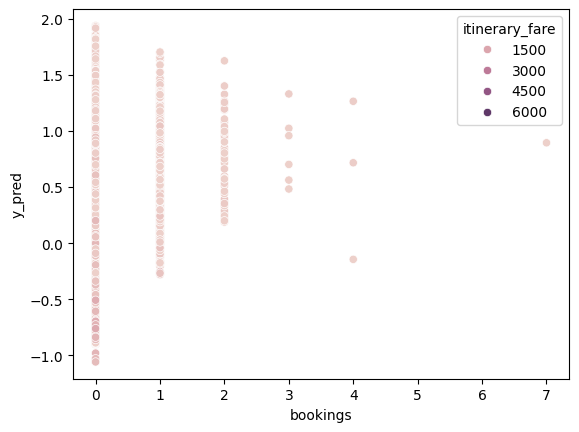

In [102]:
sns.scatterplot(data=clean_raw_dohop_data, x='bookings', y='y_pred', hue='itinerary_fare')
